# 第08章: MLPパラメータ空間の探索

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] GridSearchCVで体系的にパラメータを探索できる
- [ ] ヒートマップでパラメータの影響を可視化できる
- [ ] 最適なパラメータの組み合わせを見つけられる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ MLP基礎 ← Notebook 07
- ✅ GridSearchCV基礎

⏱️ **推定学習時間**: 90-120分  
📊 **難易度**: ★★★☆☆（中級）  
🎓 **カテゴリ**: ハイパーパラメータチューニング

---


## 💡 イントロダクション：なぜこれを学ぶのか？

### モチベーション

[この章の重要性を説明]

### 実世界での応用

[具体的な応用例]

---


In [1]:
# ============================================================
# [コードの説明]
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import (
    train_test_split, GridSearchCV, RandomizedSearchCV, 
    cross_val_score, learning_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

## Part 1: Generate Complex Dataset

In [2]:
# Generate multi-class classification data
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=3,
    n_clusters_per_class=2,
    random_state=42
)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dataset Information:")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Features: {X_train.shape[1]}")
print(f"  Classes: {len(np.unique(y))}")
print(f"  Class distribution: {np.bincount(y_train)}")

Dataset Information:
  Training samples: 1600
  Test samples: 400
  Features: 20
  Classes: 3
  Class distribution: [530 536 534]


## Part 2: Architecture Search (hidden_layer_sizes)

In [3]:
# Test different architectures
architectures = [
    # Single layer
    (10,), (25,), (50,), (100,), (200,),
    # Two layers
    (25, 10), (50, 25), (100, 50), (200, 100),
    # Three layers
    (50, 25, 10), (100, 50, 25), (200, 100, 50),
    # Four layers
    (100, 75, 50, 25)
]

results = []

for arch in architectures:
    mlp = MLPClassifier(
        hidden_layer_sizes=arch,
        activation='relu',
        solver='adam',
        alpha=0.001,
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
    )
    
    # Cross-validation
    cv_scores = cross_val_score(mlp, X_train_scaled, y_train, cv=5, scoring='accuracy')
    
    # Fit and test
    mlp.fit(X_train_scaled, y_train)
    test_acc = mlp.score(X_test_scaled, y_test)
    
    # Count parameters
    n_params = sum(w.size + b.size for w, b in zip(mlp.coefs_, mlp.intercepts_))
    
    results.append({
        'architecture': str(arch),
        'n_layers': len(arch),
        'n_params': n_params,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_acc': test_acc,
        'n_iter': mlp.n_iter_
    })

df_arch = pd.DataFrame(results).sort_values('cv_mean', ascending=False)
print("Architecture Comparison (sorted by CV accuracy):")
print(df_arch.to_string(index=False))

Architecture Comparison (sorted by CV accuracy):
     architecture  n_layers  n_params  cv_mean   cv_std  test_acc  n_iter
(100, 75, 50, 25)         4     14828 0.845625 0.018286    0.8350      31
       (200, 100)         2     24603 0.837500 0.027315    0.8375      41
   (200, 100, 50)         3     29503 0.832500 0.035827    0.8575      41
    (100, 50, 25)         3      8503 0.820625 0.017633    0.8250      32
           (200,)         1      4803 0.818750 0.024843    0.8225      79
         (50, 25)         2      2403 0.806250 0.028504    0.8100      49
        (100, 50)         2      7303 0.802500 0.023251    0.8125      42
           (100,)         1      2403 0.780000 0.040049    0.8275      63
     (50, 25, 10)         3      2618 0.775000 0.030039    0.8100      29
         (25, 10)         2       818 0.756250 0.039922    0.8025      62
            (50,)         1      1203 0.751875 0.077222    0.8325      87
            (25,)         1       603 0.738750 0.029288    0.81

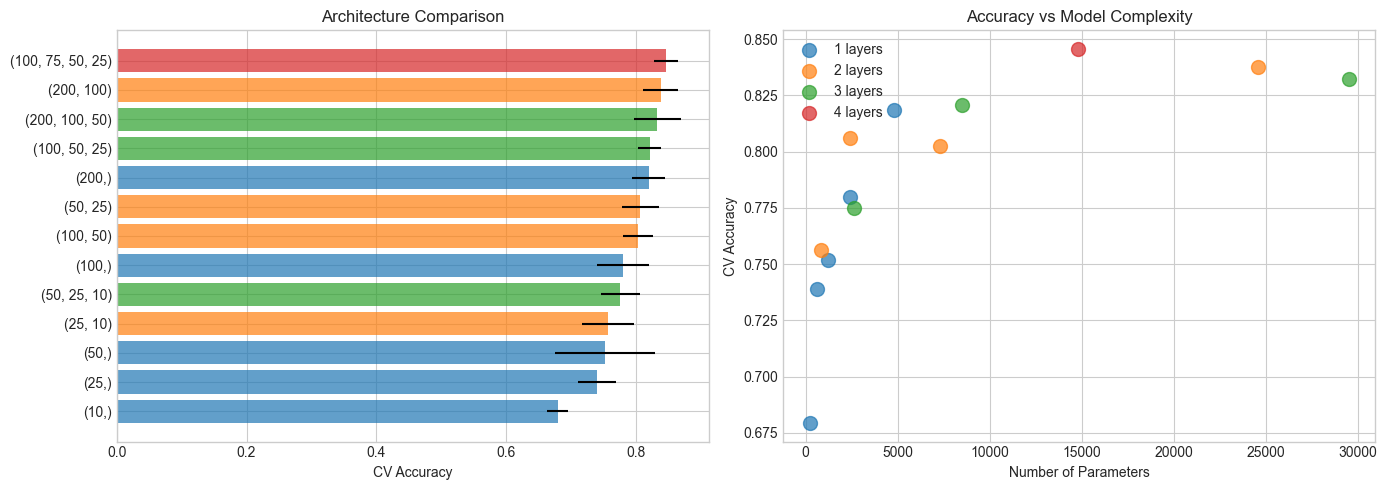

In [4]:
# Visualize architecture results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot of CV scores
df_sorted = df_arch.sort_values('cv_mean')
colors = ['C0' if l == 1 else 'C1' if l == 2 else 'C2' if l == 3 else 'C3' 
          for l in df_sorted['n_layers']]

bars = axes[0].barh(range(len(df_sorted)), df_sorted['cv_mean'], 
                    xerr=df_sorted['cv_std'], color=colors, alpha=0.7)
axes[0].set_yticks(range(len(df_sorted)))
axes[0].set_yticklabels(df_sorted['architecture'])
axes[0].set_xlabel('CV Accuracy')
axes[0].set_title('Architecture Comparison')

# Accuracy vs Parameters
for n_layers in [1, 2, 3, 4]:
    subset = df_arch[df_arch['n_layers'] == n_layers]
    axes[1].scatter(subset['n_params'], subset['cv_mean'], 
                    s=100, label=f'{n_layers} layers', alpha=0.7)
axes[1].set_xlabel('Number of Parameters')
axes[1].set_ylabel('CV Accuracy')
axes[1].set_title('Accuracy vs Model Complexity')
axes[1].legend()

plt.tight_layout()
plt.show()

## Part 3: Learning Rate and Alpha Exploration

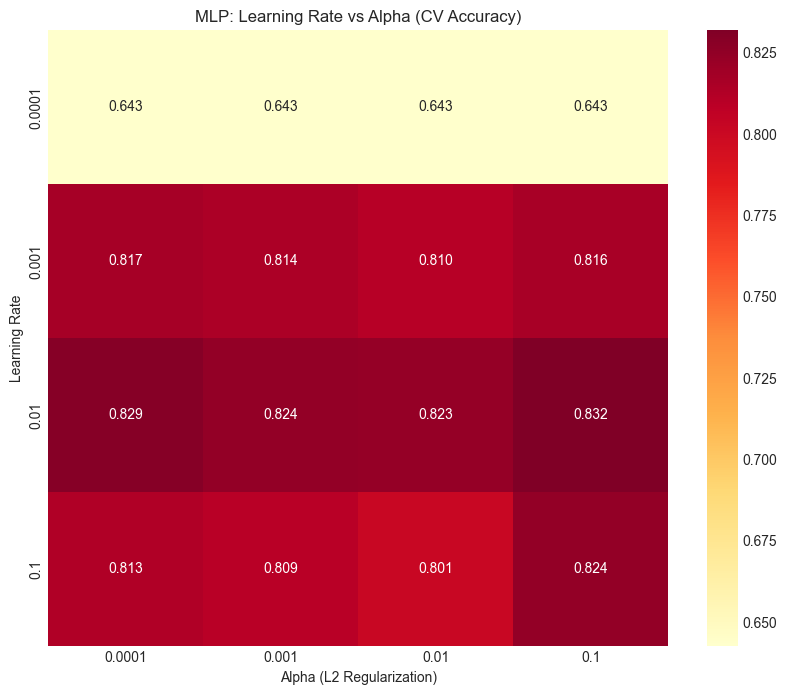

Best learning_rate: 0.01
Best alpha: 0.1
Best CV accuracy: 0.8319


In [5]:
# Grid search: learning_rate_init vs alpha
learning_rates = [0.0001, 0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01, 0.1]

results_grid = np.zeros((len(learning_rates), len(alphas)))

for i, lr in enumerate(learning_rates):
    for j, alpha in enumerate(alphas):
        mlp = MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            alpha=alpha,
            learning_rate_init=lr,
            max_iter=500,
            early_stopping=True,
            random_state=42
        )
        
        cv_scores = cross_val_score(mlp, X_train_scaled, y_train, cv=3, scoring='accuracy')
        results_grid[i, j] = cv_scores.mean()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(results_grid, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=alphas, yticklabels=learning_rates)
plt.xlabel('Alpha (L2 Regularization)')
plt.ylabel('Learning Rate')
plt.title('MLP: Learning Rate vs Alpha (CV Accuracy)')
plt.show()

# Find best combination
best_idx = np.unravel_index(np.argmax(results_grid), results_grid.shape)
print(f"Best learning_rate: {learning_rates[best_idx[0]]}")
print(f"Best alpha: {alphas[best_idx[1]]}")
print(f"Best CV accuracy: {results_grid[best_idx]:.4f}")

## Part 4: Comprehensive GridSearchCV

In [6]:
# Define comprehensive parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01],
}

# Create base model
mlp = MLPClassifier(
    solver='adam',
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

# Grid search
grid_search = GridSearchCV(
    mlp, 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                     random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 25),
                                                (100, 50)],
                         'learning_rate_init': [0.001, 0.01]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [7]:
# ============================================================
# [コードの説明]
# ============================================================

# Display best results
print("GridSearchCV Results:")
print("="*60)
print("\nBest Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score: {grid_search.best_score_:.4f}")
print(f"Test Score: {grid_search.score(X_test_scaled, y_test):.4f}")

GridSearchCV Results:

Best Parameters:
  activation: tanh
  alpha: 0.0001
  hidden_layer_sizes: (100,)
  learning_rate_init: 0.01

Best CV Score: 0.8594
Test Score: 0.8575


In [8]:
# ============================================================
# [コードの説明]
# ============================================================

# Convert results to DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Select relevant columns
cols = ['param_hidden_layer_sizes', 'param_activation', 'param_alpha', 
        'param_learning_rate_init', 'mean_test_score', 'std_test_score', 
        'mean_train_score', 'rank_test_score']
results_summary = results_df[cols].sort_values('rank_test_score')

print("\nTop 10 Parameter Combinations:")
print(results_summary.head(10).to_string(index=False))


Top 10 Parameter Combinations:
param_hidden_layer_sizes param_activation  param_alpha  param_learning_rate_init  mean_test_score  std_test_score  mean_train_score  rank_test_score
                  (100,)             tanh       0.0010                      0.01         0.859375        0.011180          0.959062                1
                  (100,)             tanh       0.0001                      0.01         0.859375        0.011180          0.959062                1
               (100, 50)             tanh       0.0001                      0.01         0.858125        0.025510          0.953594                3
               (100, 50)             tanh       0.0010                      0.01         0.858125        0.025510          0.953438                3
               (100, 50)             tanh       0.0100                      0.01         0.856250        0.025078          0.950469                5
                  (100,)             tanh       0.0100                    

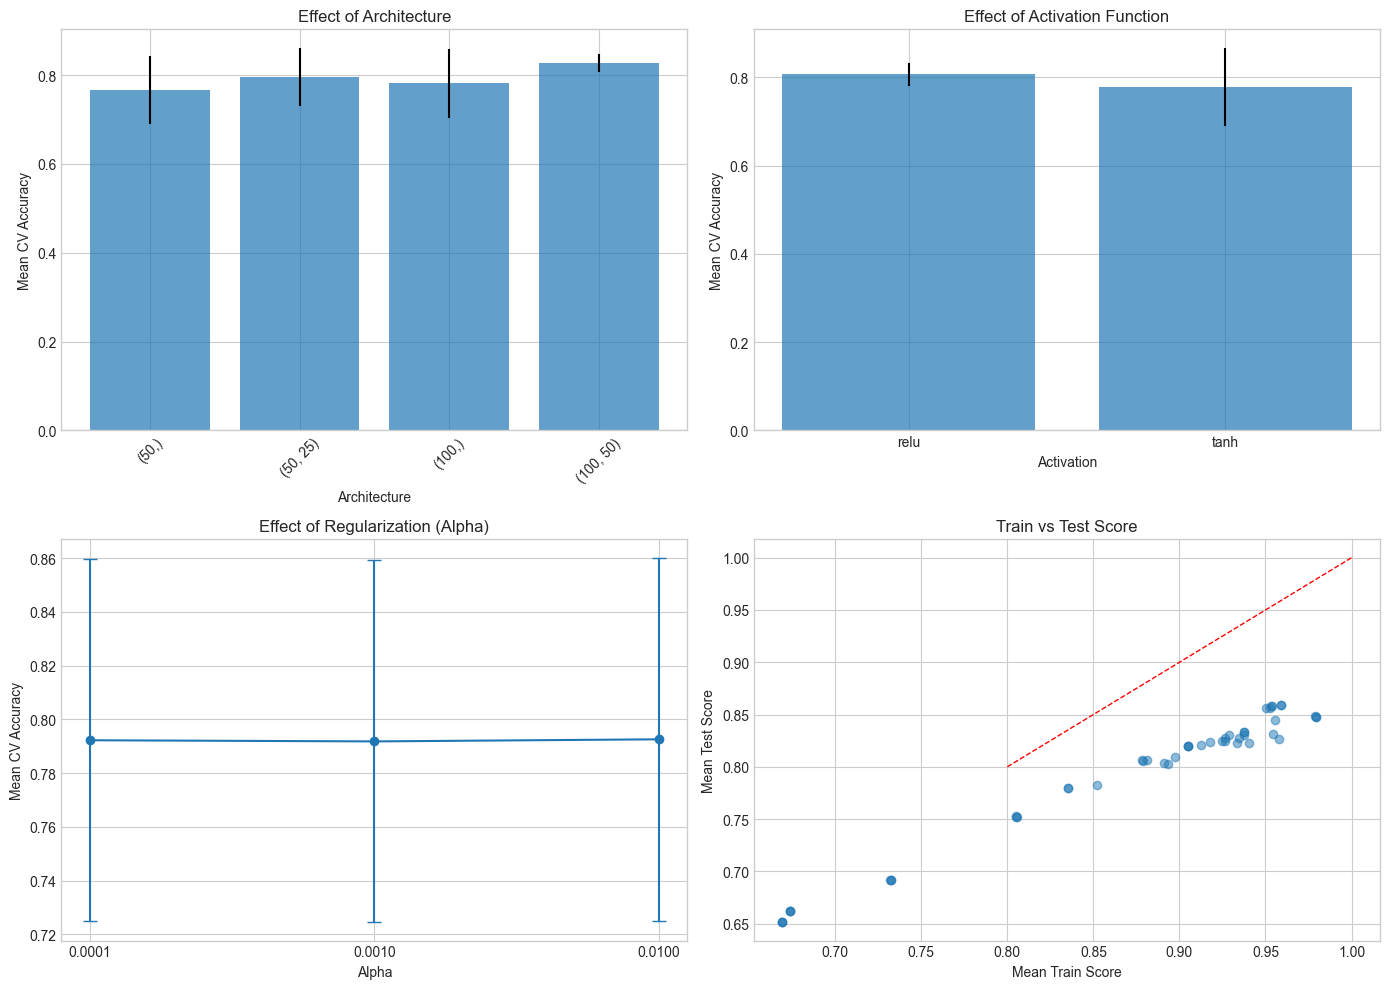

In [9]:
# Visualize GridSearchCV results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Effect of architecture
arch_results = results_df.groupby('param_hidden_layer_sizes')['mean_test_score'].agg(['mean', 'std'])
arch_labels = [str(a) for a in arch_results.index]
axes[0, 0].bar(arch_labels, arch_results['mean'], yerr=arch_results['std'], alpha=0.7)
axes[0, 0].set_xlabel('Architecture')
axes[0, 0].set_ylabel('Mean CV Accuracy')
axes[0, 0].set_title('Effect of Architecture')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Effect of activation
act_results = results_df.groupby('param_activation')['mean_test_score'].agg(['mean', 'std'])
axes[0, 1].bar(act_results.index, act_results['mean'], yerr=act_results['std'], alpha=0.7)
axes[0, 1].set_xlabel('Activation')
axes[0, 1].set_ylabel('Mean CV Accuracy')
axes[0, 1].set_title('Effect of Activation Function')

# 3. Effect of alpha
alpha_results = results_df.groupby('param_alpha')['mean_test_score'].agg(['mean', 'std'])
axes[1, 0].errorbar(range(len(alpha_results)), alpha_results['mean'], 
                    yerr=alpha_results['std'], marker='o', capsize=5)
axes[1, 0].set_xticks(range(len(alpha_results)))
axes[1, 0].set_xticklabels([f'{a:.4f}' for a in alpha_results.index])
axes[1, 0].set_xlabel('Alpha')
axes[1, 0].set_ylabel('Mean CV Accuracy')
axes[1, 0].set_title('Effect of Regularization (Alpha)')

# 4. Train vs Test score
axes[1, 1].scatter(results_df['mean_train_score'], results_df['mean_test_score'], alpha=0.5)
axes[1, 1].plot([0.8, 1], [0.8, 1], 'r--', lw=1)
axes[1, 1].set_xlabel('Mean Train Score')
axes[1, 1].set_ylabel('Mean Test Score')
axes[1, 1].set_title('Train vs Test Score')

plt.tight_layout()
plt.show()

## Part 5: Detailed Parameter Interactions

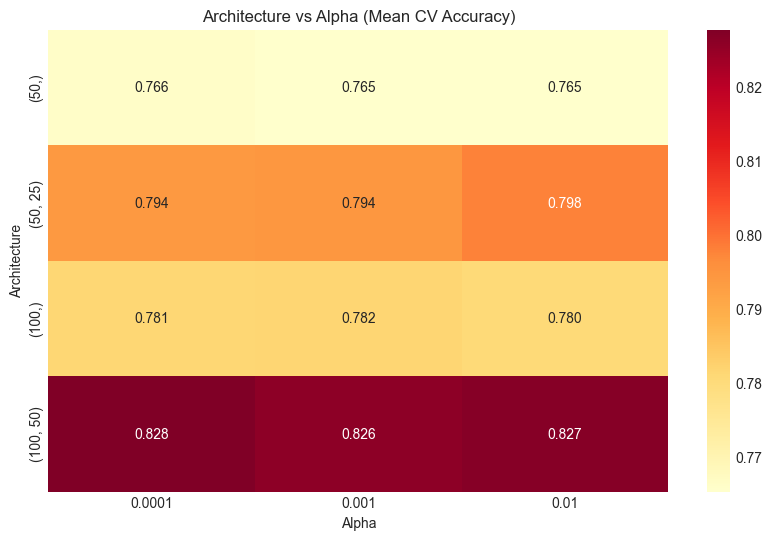

In [10]:
# ============================================================
# [コードの説明]
# ============================================================

# Architecture vs Alpha heatmap
pivot_arch_alpha = results_df.pivot_table(
    values='mean_test_score',
    index='param_hidden_layer_sizes',
    columns='param_alpha',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_arch_alpha, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Architecture vs Alpha (Mean CV Accuracy)')
plt.ylabel('Architecture')
plt.xlabel('Alpha')
plt.show()

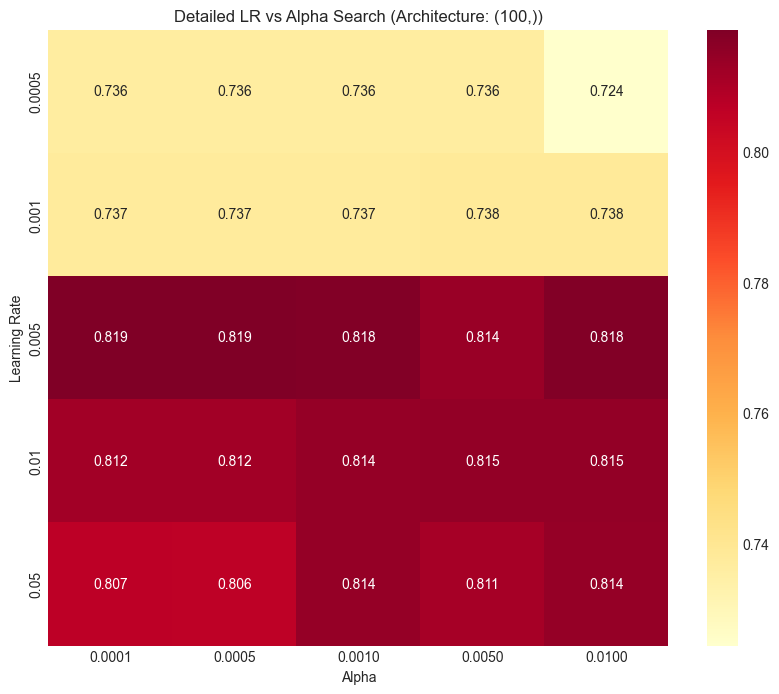

In [11]:
# ============================================================
# [コードの説明]
# ============================================================

# Learning rate vs Alpha for best architecture
best_arch = grid_search.best_params_['hidden_layer_sizes']

# More detailed search for learning rate and alpha
lr_range = [0.0005, 0.001, 0.005, 0.01, 0.05]
alpha_range = [0.0001, 0.0005, 0.001, 0.005, 0.01]

detailed_results = np.zeros((len(lr_range), len(alpha_range)))

for i, lr in enumerate(lr_range):
    for j, alpha in enumerate(alpha_range):
        mlp = MLPClassifier(
            hidden_layer_sizes=best_arch,
            activation='relu',
            solver='adam',
            alpha=alpha,
            learning_rate_init=lr,
            max_iter=500,
            early_stopping=True,
            random_state=42
        )
        cv_scores = cross_val_score(mlp, X_train_scaled, y_train, cv=3)
        detailed_results[i, j] = cv_scores.mean()

plt.figure(figsize=(10, 8))
sns.heatmap(detailed_results, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[f'{a:.4f}' for a in alpha_range],
            yticklabels=lr_range)
plt.xlabel('Alpha')
plt.ylabel('Learning Rate')
plt.title(f'Detailed LR vs Alpha Search (Architecture: {best_arch})')
plt.show()

## Part 6: RandomizedSearchCV for Larger Spaces

In [12]:
from scipy.stats import uniform, loguniform

# Define parameter distributions
param_distributions = {
    'hidden_layer_sizes': [
        (50,), (100,), (200,),
        (50, 25), (100, 50), (200, 100),
        (100, 50, 25), (200, 100, 50)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': loguniform(1e-5, 1e-1),
    'learning_rate_init': loguniform(1e-4, 1e-1),
    'batch_size': [32, 64, 128, 256]
}

# Randomized search
mlp = MLPClassifier(
    solver='adam',
    max_iter=500,
    early_stopping=True,
    random_state=42
)

random_search = RandomizedSearchCV(
    mlp,
    param_distributions,
    n_iter=50,  # Number of parameter settings to sample
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(early_stopping=True, max_iter=500,
                                           random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16c4776d0>,
                                        'batch_size': [32, 64, 128, 256],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (200,), (50, 25),
                                                               (100, 50),
                                                               (200, 100),
                                                               (100, 50, 25),
                                                               (200, 100, 50)],
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x16c07ce50>},
                   random_state=42, scoring='accuracy', verbose=1)

In [13]:
# ============================================================
# [コードの説明]
# ============================================================

# Results from randomized search
print("RandomizedSearchCV Results:")
print("="*60)
print("\nBest Parameters:")
for param, value in random_search.best_params_.items():
    if isinstance(value, float):
        print(f"  {param}: {value:.6f}")
    else:
        print(f"  {param}: {value}")

print(f"\nBest CV Score: {random_search.best_score_:.4f}")
print(f"Test Score: {random_search.score(X_test_scaled, y_test):.4f}")

RandomizedSearchCV Results:

Best Parameters:
  activation: tanh
  alpha: 0.093078
  batch_size: 32
  hidden_layer_sizes: (50, 25)
  learning_rate_init: 0.006838

Best CV Score: 0.8575
Test Score: 0.8650


## Part 7: Learning Curves for Best Model

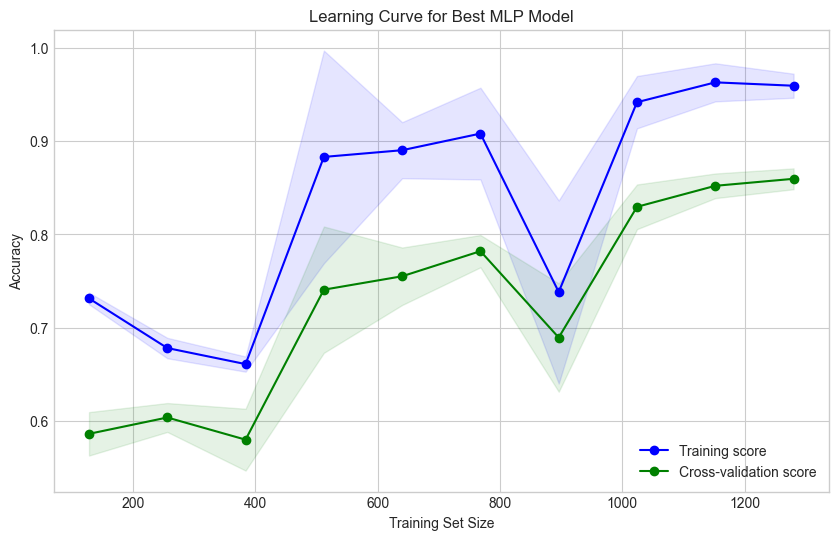

In [14]:
# Get best model
best_model = grid_search.best_estimator_

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# Plot
plt.figure(figsize=(10, 6))

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                 alpha=0.1, color='blue')

plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, 
                 alpha=0.1, color='green')

plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Best MLP Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Part 8: Final Model Evaluation

In [15]:
# Train final model with best parameters
final_model = MLPClassifier(
    **grid_search.best_params_,
    solver='adam',
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)

final_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = final_model.predict(X_test_scaled)

# Classification report
print("Final Model Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred))

Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       132
           1       0.86      0.81      0.84       134
           2       0.89      0.87      0.88       134

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



In [16]:
# ============================================================
# [コードの説明]
# ============================================================

# Final model details
print("\nFinal Model Details:")
print("="*60)
print(f"Architecture: {final_model.hidden_layer_sizes}")
print(f"Activation: {final_model.activation}")
print(f"Alpha: {final_model.alpha}")
print(f"Learning rate: {final_model.learning_rate_init}")
print(f"Iterations: {final_model.n_iter_}")
print(f"Final loss: {final_model.loss_:.6f}")

# Parameter count
n_params = sum(w.size + b.size for w, b in zip(final_model.coefs_, final_model.intercepts_))
print(f"Total parameters: {n_params}")


Final Model Details:
Architecture: (100,)
Activation: tanh
Alpha: 0.0001
Learning rate: 0.01
Iterations: 45
Final loss: 0.064584
Total parameters: 2403


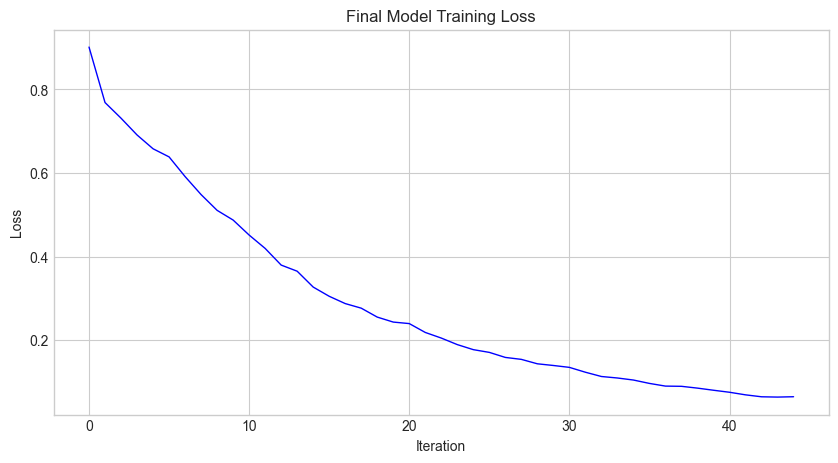

In [17]:
# ============================================================
# [コードの説明]
# ============================================================

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(final_model.loss_curve_, 'b-', linewidth=1)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Final Model Training Loss')
plt.grid(True)
plt.show()

## Part 9: Parameter Space Summary

In [18]:
# ============================================================
# [コードの説明]
# ============================================================

print("\nMLP Parameter Space Summary:")
print("="*70)
print()
print("ARCHITECTURE (hidden_layer_sizes)")
print("-" * 70)
print("  • Start: (50,) or (100,)")
print("  • Medium: (100, 50) or (50, 25)")
print("  • Deep: (100, 50, 25)")
print("  • Tip: Pyramid structure (decreasing sizes) often works well")
print()
print("ACTIVATION")
print("-" * 70)
print("  • relu: Default choice, fast training")
print("  • tanh: Better for normalized data")
print()
print("ALPHA (L2 Regularization)")
print("-" * 70)
print("  • Range: 0.0001 to 0.1")
print("  • Start: 0.001")
print("  • Increase if overfitting, decrease if underfitting")
print()
print("LEARNING_RATE_INIT")
print("-" * 70)
print("  • Range: 0.0001 to 0.1")
print("  • Start: 0.001 for Adam")
print("  • Reduce if loss oscillates")
print()
print("BATCH_SIZE")
print("-" * 70)
print("  • Range: 32 to 256")
print("  • Smaller: More noise, better generalization")
print("  • Larger: Faster training, smoother convergence")
print()
print("SOLVER")
print("-" * 70)
print("  • adam: Best default choice")
print("  • sgd: When you need momentum/learning rate schedules")
print("  • lbfgs: For small datasets")


MLP Parameter Space Summary:

ARCHITECTURE (hidden_layer_sizes)
----------------------------------------------------------------------
  • Start: (50,) or (100,)
  • Medium: (100, 50) or (50, 25)
  • Deep: (100, 50, 25)
  • Tip: Pyramid structure (decreasing sizes) often works well

ACTIVATION
----------------------------------------------------------------------
  • relu: Default choice, fast training
  • tanh: Better for normalized data

ALPHA (L2 Regularization)
----------------------------------------------------------------------
  • Range: 0.0001 to 0.1
  • Start: 0.001
  • Increase if overfitting, decrease if underfitting

LEARNING_RATE_INIT
----------------------------------------------------------------------
  • Range: 0.0001 to 0.1
  • Start: 0.001 for Adam
  • Reduce if loss oscillates

BATCH_SIZE
----------------------------------------------------------------------
  • Range: 32 to 256
  • Smaller: More noise, better generalization
  • Larger: Faster training, smoother c

## Summary

In this notebook, you learned:

### Parameter Exploration Techniques
- Manual parameter sweeps
- GridSearchCV for exhaustive search
- RandomizedSearchCV for large parameter spaces

### Key Parameters for MLP
- **hidden_layer_sizes**: Architecture definition
- **alpha**: L2 regularization strength
- **learning_rate_init**: Initial learning rate
- **activation**: Activation function
- **batch_size**: Mini-batch size

### Visualization Methods
- Heatmaps for parameter interactions
- Bar plots for comparing configurations
- Learning curves for diagnostics

### Key Takeaways
- Start with moderate architecture, tune from there
- Use GridSearchCV for small parameter spaces
- Use RandomizedSearchCV for large spaces
- Always validate with learning curves
- Early stopping prevents overfitting

### Next Steps
Continue to **Notebook 09** for MLP regression with waveform prediction!

### ⚠️ よくあるエラー #1: データのスケーリング忘れ

機械学習モデル（特にニューラルネットワーク）でデータをスケーリングしないと性能が低下します。

**原因:**
1. `StandardScaler`を使わずに生データを入力
2. 訓練セットとテストセットで異なるscalerを使用

**✅ 解決法:**

```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # fit_transformではない！
```

---


### ⚠️ よくあるエラー #2: データリーク

テストセットの情報が訓練に漏れると、評価が不正確になります。

**原因:**
1. テストセットで`fit_transform`を使う
2. スケーリング前にデータ分割

**✅ 解決法:**

```python
# ✅ 正しい順序
# 1. データ分割
X_train, X_test, y_train, y_test = train_test_split(X, y)
# 2. スケーリング（訓練セットでfit）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # transformのみ
```

---


---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ特徴量のスケーリングが重要なのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 機械学習アルゴリズムはスケールに敏感だから

特にニューラルネットワークや距離ベースのアルゴリズム（SVM、k-NN）は、特徴量のスケールが異なると正しく学習できません。StandardScalerで平均0、標準偏差1に正規化することで、全ての特徴量を同じスケールにできます。

</details>

---

### Q2: 訓練セットとテストセットで別々にスケーリングしてはいけない理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**: データリークが発生し、評価が不正確になるから

テストセットで`fit_transform`を使うと、テストセットの統計量（平均、標準偏差）を使ってスケーリングしてしまいます。これは本番環境では利用できない情報なので、評価が楽観的になります。必ず訓練セットの統計量を使って`transform`のみ行います。

</details>

---



---

## ➡️ 次のステップ

### 学習を続ける

**📗 Notebook 09: MLP Regression**

### 復習が必要な場合

- **Notebook 02: 前処理**
- **Notebook 03: 評価指標**

### さらに学ぶために

**書籍:**
- "Hands-On Machine Learning" by Aurélien Géron
- "Pattern Recognition and Machine Learning" by Christopher Bishop

**オンラインリソース:**
- scikit-learn documentation: https://scikit-learn.org
- Kaggle: 実データで練習
- UCI ML Repository: データセット

---

### 🎉 お疲れ様でした！

次の章でさらに深く探求しましょう！
